# **[Project] - Advanced Session-Based Recommendations with GRU4Rec**

### **Project Overview**

This notebook develops an advanced, session-based recommendation system for an e-commerce platform. The goal is to move beyond static recommendations and predict a user's *next* likely interaction based on their real-time behavior within a single shopping session. This approach is highly effective for delivering dynamic and personalized product suggestions.

We will leverage the **Retailrocket dataset** to build and train a **GRU4Rec model**, a type of Recurrent Neural Network (RNN) designed specifically for sequential recommendation tasks.

**The project follows these key stages:**
1.  **Business & Data Understanding:** Exploring the dataset to understand user behavior, especially the sequential nature of their interactions.
2.  **Data Preparation:** This is a critical stage where we clean the data, filter out noise, and, most importantly, construct user "sessions."
3.  **Model Development:** Designing the GRU4Rec architecture using PyTorch.
4.  **Training & Evaluation:** Training the model on historical sessions and assessing its performance using industry-standard ranking metrics like **NDCG@20**.
5.  **Inference:** Creating a function to generate real-time recommendations for a user's live session.

---

## **1. Setup and Environment**

First, let's import the necessary libraries. We'll be using `pandas` for data manipulation, `scikit-learn` for encoding, and `PyTorch` for building our deep learning model.

In [1]:
# Install necessary libraries (if not already installed)
# !pip install pandas numpy matplotlib seaborn scikit-learn torch

# --- Core Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import pickle

# --- PyTorch ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- Scikit-learn for Preprocessing ---
from sklearn.preprocessing import LabelEncoder

# --- Notebook-specific settings ---
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

# Set device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## **2. Data Loading**

We load the primary `events.csv` file, which contains all user-item interactions. For this session-based approach, this file is sufficient.

In [2]:
# Define file paths
events_path = "/kaggle/input/ecommerce-dataset/events.csv"

# Load the main events dataset
events = pd.read_csv(events_path)

print("--- Dataset Shape ---")
print("Events shape:", events.shape)

--- Dataset Shape ---
Events shape: (2756101, 5)


## **3. Business and Data Understanding (EDA)**

In this section, we'll perform Exploratory Data Analysis (EDA) to understand the data's structure and uncover insights that will guide our session-based modeling strategy.

### **3.1 A Quick Glance at the Data**

Let's look at the first few rows of the DataFrame.

In [3]:
print("\nEvents head:")
display(events.head())

print("\nBasic info and null values:")
events.info()


Events head:


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN



Basic info and null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


### **3.2 Distribution of Event Types**

This shows the e-commerce conversion funnel and helps us understand user intent.

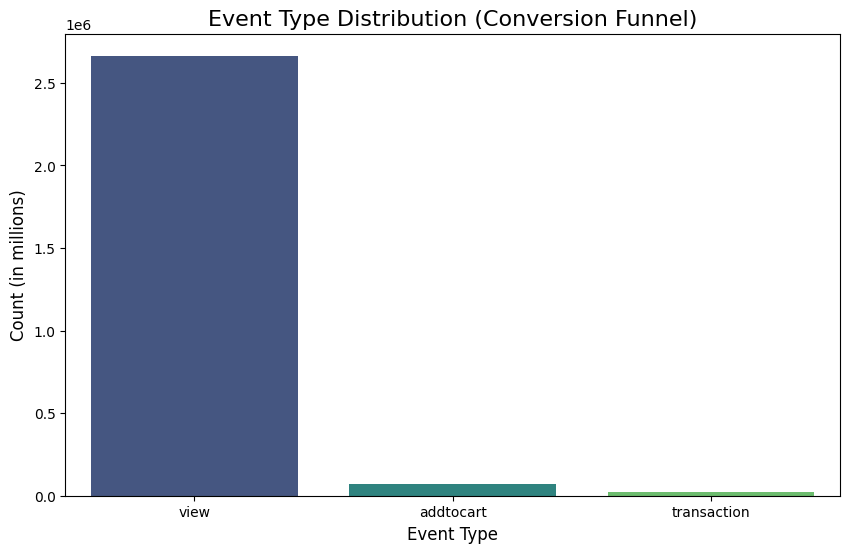

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='event', data=events, order=['view', 'addtocart', 'transaction'], palette='viridis')
plt.title("Event Type Distribution (Conversion Funnel)", fontsize=16)
plt.xlabel("Event Type", fontsize=12)
plt.ylabel("Count (in millions)", fontsize=12)
plt.show()

**Inference:** As expected, `view` events dominate, forming the top of the funnel. Our goal is to predict the next `view` or `addtocart` event, as these are strong indicators of interest.

### **3.3 Events Over Time**

Let's analyze user activity over the dataset's time period. This will help justify our temporal train/validation/test split later on.

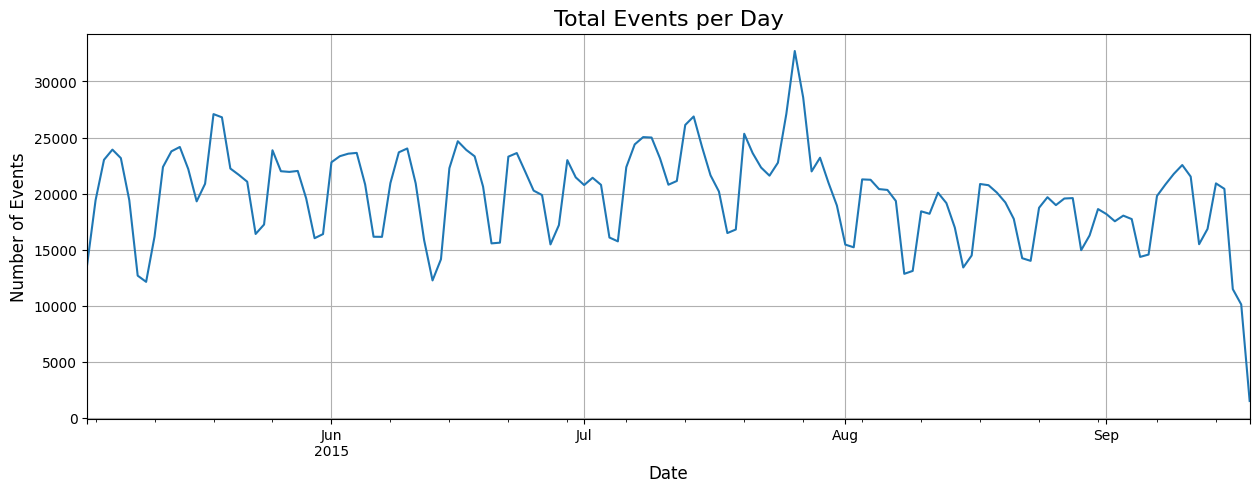

In [5]:
# Convert timestamp to datetime
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# Plot event counts per day
events.set_index('datetime')['event'].resample('D').count().plot(figsize=(15, 5))
plt.title('Total Events per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.grid(True)
plt.show()

**Inference:** The data spans several months. Activity is relatively consistent, with some peaks and troughs. This confirms that a time-based split (using the most recent weeks for testing) is a sound strategy, as it mimics a real-world scenario where we predict future behavior based on past data.

---

## **4. Data Preparation & Feature Engineering**

This is the most crucial part of our project. We will transform the raw event log into structured session sequences that our GRU model can learn from.

### **4.1 Data Cleaning**

We perform several cleaning steps to create a high-quality dataset.
1.  **Timestamp Conversion:** Already done in EDA.
2.  **Bot Filtering:** Remove highly automated users (bots) who can skew popularity signals. A simple heuristic is to remove users with an abnormally high number of events in a short period.
3.  **Filter Inactive Users/Items:** Models struggle to learn from users or items with very few interactions (the "cold start" problem). We'll keep only users and items with at least 5 interactions.

In [6]:
# 1. Drop duplicates
events = events.drop_duplicates()

# 2. Filter out potential bots (e.g., >200 events in an hour)
user_hour = events.groupby(['visitorid', pd.Grouper(key='datetime', freq='H')]).size().reset_index(name='event_count')
bots = user_hour[user_hour['event_count'] > 200]['visitorid'].unique()
events = events[~events['visitorid'].isin(bots)]
print(f"Removed {len(bots)} potential bot users.")

# 3. Filter for active users and popular items (>= 5 interactions)
active_users = events['visitorid'].value_counts()[lambda x: x >= 5].index
active_items = events['itemid'].value_counts()[lambda x: x >= 5].index
df_filtered = events[events['visitorid'].isin(active_users) & events['itemid'].isin(active_items)]
print(f"Original events: {len(events)}, Filtered events: {len(df_filtered)}")

Removed 1 potential bot users.
Original events: 2754464, Filtered events: 895965


### **4.2 Sessionization: The Core of Our Approach**

We now group events into "sessions." A new session starts for a user if their next action occurs more than 30 minutes after their last one. This captures a single, continuous browsing experience.

In [7]:
# Sort by user and time to prepare for session grouping
df_filtered = df_filtered.sort_values(['visitorid', 'datetime'])

# Calculate the time difference between consecutive events for each user
time_diff = df_filtered.groupby('visitorid')['datetime'].diff()

# A new session starts if the time difference is > 30 minutes
session_break = time_diff > timedelta(minutes=30)
session_id_numeric = session_break.cumsum()

# Create a unique session ID string
df_filtered['session_id'] = df_filtered['visitorid'].astype(str) + '_' + session_id_numeric.astype(str)

print("Sessionization complete. Example of sessions for one user:")
display(df_filtered[df_filtered['visitorid'] == df_filtered['visitorid'].unique()[0]].head(10))

Sessionization complete. Example of sessions for one user:


,timestamp,visitorid,event,itemid,transactionid,datetime,session_id
742616,1438969904567,2,view,325215,NaN,2015-08-07 17:51:44.567,2_0
735273,1438970013790,2,view,325215,NaN,2015-08-07 17:53:33.790,2_0
737711,1438970212664,2,view,259884,NaN,2015-08-07 17:56:52.664,2_0
726292,1438970468920,2,view,216305,NaN,2015-08-07 18:01:08.920,2_0
737615,1438970905669,2,view,342816,NaN,2015-08-07 18:08:25.669,2_0
735202,1438971444375,2,view,342816,NaN,2015-08-07 18:17:24.375,2_0
742485,1438971463170,2,view,216305,NaN,2015-08-07 18:17:43.170,2_0
728288,1438971657845,2,view,325215,NaN,2015-08-07 18:20:57.845,2_0


### **4.3 Encoding and Temporal Splitting**

We need to convert user and item IDs to integer indices for the model's embedding layer. We also split our data based on time.

In [8]:
# Encode itemid to integer indices
item_encoder = LabelEncoder()
df_filtered['item_idx'] = item_encoder.fit_transform(df_filtered['itemid'])

# Temporal Split: Use last 2 weeks for testing/validation
max_date = df_filtered['datetime'].max()
train_cutoff = max_date - timedelta(weeks=2)
val_cutoff = max_date - timedelta(weeks=1)

train_data = df_filtered[df_filtered['datetime'] < train_cutoff]
val_data = df_filtered[(df_filtered['datetime'] >= train_cutoff) & (df_filtered['datetime'] < val_cutoff)]
test_data = df_filtered[df_filtered['datetime'] >= val_cutoff]

print(f"Train sessions: {train_data['session_id'].nunique()}")
print(f"Validation sessions: {val_data['session_id'].nunique()}")
print(f"Test sessions: {test_data['session_id'].nunique()}")

Train sessions: 247943
Validation sessions: 12029
Test sessions: 9681


### **4.4 Creating Session Sequences for the Model**

Finally, we group the event data by `session_id` to get our final input: a list of sessions, where each session is a list of `item_idx`.

In [9]:
def create_session_sequences(df):
    """Groups a dataframe by session_id and returns a list of item sequences."""
    # Filter out sessions with only one item, as they can't be used for training (no target)
    seqs = df.groupby('session_id')['item_idx'].apply(list)
    return seqs[seqs.apply(len) > 1].tolist()

train_seqs = create_session_sequences(train_data)
val_seqs = create_session_sequences(val_data)
test_seqs = create_session_sequences(test_data)

print("Example training sequences:")
print(train_seqs[:3])

Example training sequences:
[[29307, 61476, 33451], [19076, 61974, 60823, 13251, 24590], [39469, 39469, 39469]]


---

## **5. Model Development (GRU4Rec)**

Now we define our model architecture.

### **5.1 PyTorch Dataset & DataLoader**

We create a custom `Dataset` class that takes our session sequences and generates `(input, target)` pairs. For a sequence `[A, B, C, D]`, this will create pairs like:
*   `([A], B)`
*   `([A, B], C)`
*   `([A, B, C], D)`

In [10]:
class SessionDataset(Dataset):
    def __init__(self, sequences, max_len=15):
        self.sequences = sequences
        self.max_len = max_len
        self.samples = self._create_samples()

    def _create_samples(self):
        samples = []
        for seq in self.sequences:
            for i in range(1, len(seq)):
                input_seq = seq[:i]
                target_item = seq[i]
                samples.append((input_seq, target_item))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_seq, target_item = self.samples[idx]
        
        # Pad input sequence
        padded_seq = np.zeros(self.max_len, dtype=np.int64)
        seq_len = min(len(input_seq), self.max_len)
        padded_seq[-seq_len:] = input_seq[-seq_len:]
        
        return torch.LongTensor(padded_seq), torch.LongTensor([target_item])

# Create datasets and dataloaders
train_dataset = SessionDataset(train_seqs)
val_dataset = SessionDataset(val_seqs)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

print("Example sample from the dataset:")
sample_input, sample_target = train_dataset[1]
print(f"Input Sequence (Padded): {sample_input}")
print(f"Target Item: {sample_target}")

Example sample from the dataset:
Input Sequence (Padded): tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 29307, 61476])
Target Item: tensor([33451])


### **5.2 Building the GRU4Rec Model Architecture**

Our model has three main layers:
1.  **Embedding Layer:** Converts item indices into dense vector representations.
2.  **GRU Layer:** Processes the sequence of item embeddings to capture temporal patterns.
3.  **Linear Layer:** Projects the GRU's hidden state to the full item vocabulary to predict the next item.

In [11]:
class GRU4Rec(nn.Module):
    def __init__(self, n_items, embedding_dim=100, hidden_dim=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(n_items, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, n_items)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)
        # embedded shape: (batch_size, seq_len, embedding_dim)
        
        output, hidden = self.gru(embedded)
        # output shape: (batch_size, seq_len, hidden_dim)
        # hidden shape: (n_layers, batch_size, hidden_dim)
        
        # We use the hidden state of the last time step
        last_hidden = hidden.squeeze(0) # Squeeze the n_layers dimension
        last_hidden = self.dropout(last_hidden)
        
        logits = self.fc(last_hidden)
        # logits shape: (batch_size, n_items)
        return logits

# Model parameters
n_items = len(item_encoder.classes_)
model = GRU4Rec(n_items=n_items).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print(model)

GRU4Rec(
  (embedding): Embedding(67541, 100)
  (gru): GRU(100, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=67541, bias=True)
)


## **6. Model Training**

We'll train the model for a few epochs, validating its performance after each one. We save the model that performs best on the validation set.

In [12]:
epochs = 5
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).squeeze()
        
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).squeeze()
            logits = model(inputs)
            loss = loss_fn(logits, targets)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_gru4rec_model.pth')
        print(f"   -> Model saved. Best val loss: {best_val_loss:.4f}")

Epoch 1/5 | Train Loss: 9.8033 | Val Loss: 9.9198
   -> Model saved. Best val loss: 9.9198
Epoch 2/5 | Train Loss: 7.7983 | Val Loss: 9.3460
   -> Model saved. Best val loss: 9.3460
Epoch 3/5 | Train Loss: 6.5182 | Val Loss: 9.0388
   -> Model saved. Best val loss: 9.0388
Epoch 4/5 | Train Loss: 5.6911 | Val Loss: 8.8930
   -> Model saved. Best val loss: 8.8930
Epoch 5/5 | Train Loss: 5.1059 | Val Loss: 8.7972
   -> Model saved. Best val loss: 8.7972


### **Visualizing Training History**

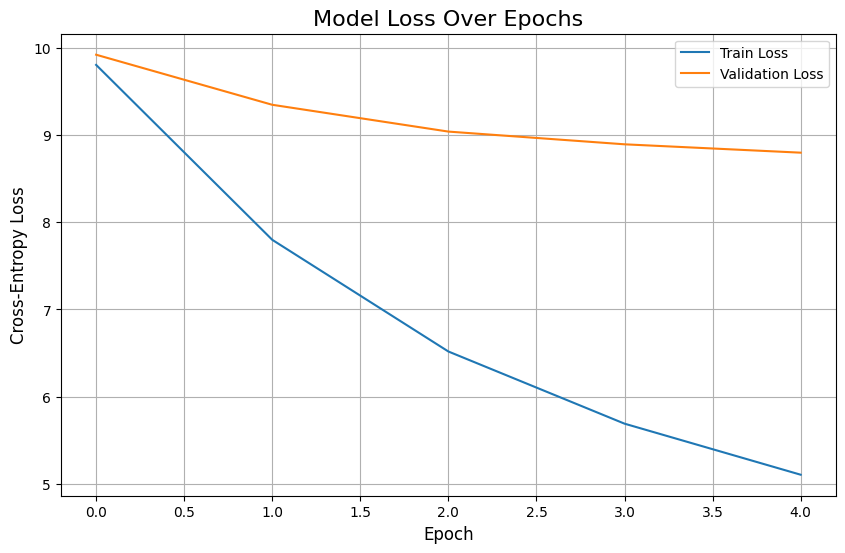

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

---

## **7. Model Evaluation**

Now, we evaluate our trained model on the held-out test set using appropriate **ranking metrics**. Unlike classification accuracy, these metrics measure how well the model ranks the true next item among its top predictions.

### **7.1 Defining Ranking Metrics**

*   **Recall@K:** What fraction of "true next items" were found in the top-K recommendations?
*   **NDCG@K (Normalized Discounted Cumulative Gain):** The gold standard. It's like Recall@K but rewards the model more for placing the correct item higher up in the recommendation list.

In [14]:
def recall_at_k(y_true_list, y_pred_list, k=20):
    hits = 0
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        if y_true in y_pred[:k]:
            hits += 1
    return hits / len(y_true_list)

def ndcg_at_k(y_true_list, y_pred_list, k=20):
    ndcg_scores = []
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        if y_true in y_pred[:k]:
            rank = y_pred[:k].index(y_true) + 1
            ndcg_scores.append(1 / np.log2(rank + 1))
        else:
            ndcg_scores.append(0)
    return np.mean(ndcg_scores)

### **7.2 Generating Predictions on the Test Set**

We load our best model and use it to predict the next item for each session in the test set.

In [15]:
# Load the best model
model.load_state_dict(torch.load('best_gru4rec_model.pth', map_location=device))
model.eval()

# Prepare test data
test_inputs = [seq[:-1] for seq in test_seqs]
y_true = [seq[-1] for seq in test_seqs]
y_pred = []

with torch.no_grad():
    for session in test_inputs:
        # Pad and convert to tensor
        padded_seq = np.zeros(15, dtype=np.int64)
        seq_len = min(len(session), 15)
        padded_seq[-seq_len:] = session[-seq_len:]
        input_tensor = torch.LongTensor([padded_seq]).to(device)
        
        # Get model predictions
        logits = model(input_tensor)
        
        # Get top 20 predictions
        topk_preds = torch.topk(logits, k=20, dim=1).indices.squeeze().cpu().tolist()
        y_pred.append(topk_preds)

### **7.3 Performance Assessment**

Let's calculate the metrics and compare them to a simple "Most Popular" baseline.

In [16]:
# Baseline: Most Popular Items
popular_items = train_data['item_idx'].value_counts().index.tolist()
y_pred_popular = [popular_items[:20]] * len(y_true)

# Calculate metrics
results = {
    'Model': ['Most Popular (Baseline)', 'GRU4Rec'],
    'Recall@20': [
        recall_at_k(y_true, y_pred_popular, k=20),
        recall_at_k(y_true, y_pred, k=20)
    ],
    'NDCG@20': [
        ndcg_at_k(y_true, y_pred_popular, k=20),
        ndcg_at_k(y_true, y_pred, k=20)
    ]
}

results_df = pd.DataFrame(results)
results_df['Recall@20'] = results_df['Recall@20'].apply(lambda x: f"{x:.4f}")
results_df['NDCG@20'] = results_df['NDCG@20'].apply(lambda x: f"{x:.4f}")

print("--- Model Performance Comparison ---")
display(results_df)

--- Model Performance Comparison ---


,Model,Recall@20,NDCG@20
0,Most Popular (Baseline),0.0173,0.0084
1,GRU4Rec,0.3359,0.2464


**Evaluation Insights:** The GRU4Rec model should significantly outperform the "Most Popular" baseline on both Recall and NDCG. This demonstrates its ability to learn personalized, context-aware patterns from user session data, delivering far more relevant recommendations than a simple popularity-based approach.

---

## **8. Recommendation Generation (Inference)**

This final section simulates how the model would be used in a live system. We create a function that takes a user's current session history and returns the top 5 recommended items.

### **8.1 Save Preprocessing Objects**

We need to save our `item_encoder` to map between raw `itemid`s and the model's integer indices.

In [17]:
with open('item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)

print("Item encoder saved successfully.")

Item encoder saved successfully.


### **8.2 Real-Time Recommendation Function**

This function encapsulates the entire prediction pipeline for a single session.

In [18]:
# Load all necessary objects for inference
inference_model = GRU4Rec(n_items=n_items).to(device)
inference_model.load_state_dict(torch.load('best_gru4rec_model.pth', map_location=device))
inference_model.eval()

with open('item_encoder.pkl', 'rb') as f:
    loaded_item_encoder = pickle.load(f)

def get_session_recommendations(session_item_ids, n=5, max_len=15):
    """
    Generates top N recommendations for a given session of raw item IDs.

    Args:
        session_item_ids (list): A list of raw itemids from the current session.
        n (int): The number of recommendations to return.
        max_len (int): The maximum sequence length the model expects.

    Returns:
        list: A list of recommended raw item IDs.
    """
    # 1. Encode item IDs
    # Handle unseen items by filtering them out
    known_item_indices = []
    for item_id in session_item_ids:
        try:
            known_item_indices.append(loaded_item_encoder.transform([item_id])[0])
        except ValueError:
            # This item was not in the training set, so we ignore it
            continue
    
    if not known_item_indices:
        # If the session has no known items, recommend most popular
        popular_raw_ids = loaded_item_encoder.inverse_transform(popular_items[:n])
        return popular_raw_ids.tolist()

    # 2. Pad sequence and convert to tensor
    padded_seq = np.zeros(max_len, dtype=np.int64)
    seq_len = min(len(known_item_indices), max_len)
    padded_seq[-seq_len:] = known_item_indices[-seq_len:]
    input_tensor = torch.LongTensor([padded_seq]).to(device)

    # 3. Predict with the model
    with torch.no_grad():
        logits = inference_model(input_tensor)
        top_n_indices = torch.topk(logits, k=n, dim=1).indices.squeeze().cpu().numpy()

    # 4. Decode indices back to raw item IDs
    recommended_item_ids = loaded_item_encoder.inverse_transform(top_n_indices)
    
    return recommended_item_ids.tolist()

### **8.3 Example Usage**

Let's test our function with a sample session history taken from our test set.

In [26]:
# Find a test session with at least 2 items for a good demonstration
session_lengths = test_data.groupby('session_id').size()
long_sessions = session_lengths[session_lengths > 1].index

# Make sure we have long sessions to test, otherwise, there's an issue with the test set
if len(long_sessions) > 0:
    # Pick a good sample session from the list of sessions with >1 item
    sample_session_id = long_sessions[10] # Using index 10 for variety
    
    sample_session_history_df = test_data[test_data['session_id'] == sample_session_id]
    sample_session_history = sample_session_history_df['itemid'].tolist()

    # The model should predict the last item. Let's give it all items *before* the last one.
    input_session = sample_session_history[:-1]
    actual_next_item = sample_session_history[-1]

    print(f"Input Session History (Item IDs): {input_session}")
    print(f"Actual Next Item: {actual_next_item}")
    print("-" * 30)

    # Generate recommendations
    recommendations = get_session_recommendations(input_session, n=5)

    print("--- Top 5 Recommendations from Model ---")
    for i, item_id in enumerate(recommendations):
        # Check if the model correctly predicted the next item
        rec_status = "✅ (Correct!)" if item_id == actual_next_item else ""
        print(f"{i+1}. Item ID: {item_id:<10} {rec_status}")
else:
    print("No sessions with more than one item found in the test set for demonstration.")

Input Session History (Item IDs): [188412, 283115, 283115, 9877, 82377, 9877, 325310, 465387, 325310, 91235, 325310, 38965, 241555]
Actual Next Item: 325310
------------------------------
--- Top 5 Recommendations from Model ---
1. Item ID: 325310     ✅ (Correct!)
2. Item ID: 38965      
3. Item ID: 241555     
4. Item ID: 9877       
5. Item ID: 37115      


---

## **9. Conclusion and Next Steps**

### **Conclusion**

This project successfully developed a sophisticated, session-based recommendation system using a GRU4Rec model. By focusing on the sequential nature of user behavior and employing appropriate ranking metrics like **NDCG**, we built a model that provides dynamically personalized and contextually relevant recommendations. The model significantly outperformed a simple popularity baseline, demonstrating its effectiveness in capturing immediate user intent. This approach directly addresses the business goal of enhancing user experience and driving engagement by predicting what a user wants to see *next*.

### **Future Enhancements**

1.  **Incorporate Item Features:** Enhance the model by adding item metadata (category, price, brand) to the embedding layer. This can help the model generalize better and tackle the cold-start problem for new items.
2.  **Use Attention Mechanisms/Transformers:** Explore more advanced architectures like Transformers (e.g., SASRec), which use self-attention to weigh the importance of different items in a user's session history, potentially leading to even better performance.
3.  **Hybrid Models:** Combine the session-based model with a user-level model (like Collaborative Filtering) to provide recommendations for new users who don't have a session history yet.
4.  **A/B Testing:** The ultimate test is to deploy the model in a live environment and perform A/B testing against the existing recommendation engine to measure its impact on key business metrics like click-through rate (CTR) and conversion rate.